<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/Clav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

In [1]:
!pip install kaggle

In [2]:
from google. colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnaschavan","key":"6f1c6fc054fb8d6259f3b6411ea6191e"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

100% 6.40G/6.40G [03:36<00:00, 23.2MB/s]
100% 6.40G/6.40G [03:36<00:00, 31.8MB/s]


# Data preprocessing

In [7]:
import zipfile
zip_r = zipfile.ZipFile('/content/cervical-cancer-largest-dataset-sipakmed.zip')
zip_r.extractall()
zip_r.close()

In [8]:
!mkdir Data

In [34]:
one = "/content/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
two = "/content/im_Koilocytotic/im_Koilocytotic/CROPPED/"
three = "/content/im_Metaplastic/im_Metaplastic/CROPPED/"
four = "/content/im_Parabasal/im_Parabasal/CROPPED/"
five = "/content/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

In [35]:
path = [one,two,three,four,five]

In [45]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data = []
labels = []
height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                print(p+a)
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except:
                print('')
    i+=1

In [39]:
# Converting data to ndarray -
labels = np.array(labels)
data = np.array(data)

In [40]:
print(data.shape)
print(labels.shape)
print(labels)

(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


In [53]:
# Shuffling data
np.random.seed(42)
s = np.arange(data.shape[0])
np.random.shuffle(s)
data = data[s]
labels = labels[s]

In [54]:
labels

array([1, 0, 4, ..., 1, 4, 3])

In [55]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

In [56]:
def img(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

In [ ]:
img(1)

# Method not my

In [70]:
from tensorflow.keras.applications.resnet import ResNet50 as tres
from keras.applications.resnet import ResNet50 as kres

In [71]:
model_t_resnet=tres(weights='imagenet',include_top = False)
model_k_resnet=kres(weights='imagenet',include_top = False)

94765736/94765736 [==============================] - 3s 0us/step


In [72]:
features_t_resnet = model_t_resnet.predict(data, batch_size=32)
features_k_resnet = model_k_resnet.predict(data, batch_size=32)

127/127 [==============================] - 2s 10ms/step


In [73]:
print(features_t_resnet.shape)
print(features_k_resnet.shape)

(4049, 2, 2, 2048)
(4049, 2, 2, 2048)


In [75]:
features_t_resnet[0]

(2, 2, 2048)

(4049, 64, 64, 3)

In [81]:
extracted_features = []

In [82]:
for f_r, f_d, label in zip(features_t_resnet, features_k_resnet,labels):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, label)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 16385)


In [85]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [84]:
X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [86]:
pca = PCA(n_components = 0.95)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)

In [87]:
print(len(pca.components_))
print(pca.explained_variance_ratio_)

1643
[6.17855914e-02 5.19912359e-02 3.81364119e-02 ... 6.13230908e-05
 6.12653761e-05 6.11808039e-05]


In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(3239, 1643)
(810, 1643)
(3239,)
(810,)


In [90]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [91]:
history_rsenet_1 = model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
102/102 [==============================] - 2s 3ms/step - loss: 0.8371 - accuracy: 0.7379
Epoch 2/10
102/102 [==============================] - 0s 4ms/step - loss: 0.2121 - accuracy: 0.9509
Epoch 3/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9861
Epoch 4/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0541 - accuracy: 0.9926
Epoch 5/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0319 - accuracy: 0.9975
Epoch 6/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.9978
Epoch 7/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0150 - accuracy: 0.9991
Epoch 8/10
102/102 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.9997
Epoch 9/10
102/102 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 0.9997
Epoch 10/10
102/102 [==============================] - 0s 3ms/step - loss: 0.0066 - accuracy: 0.9997

In [93]:
y_pred = model.predict(X_test)
val = np.argmax(y_pred, axis=1)

26/26 [==============================] - 0s 3ms/step


In [100]:
y_pred.shape

(810, 5)

In [94]:
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10):
  # Create the confustion matrix
  cm = confusion_matrix(y_true,y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

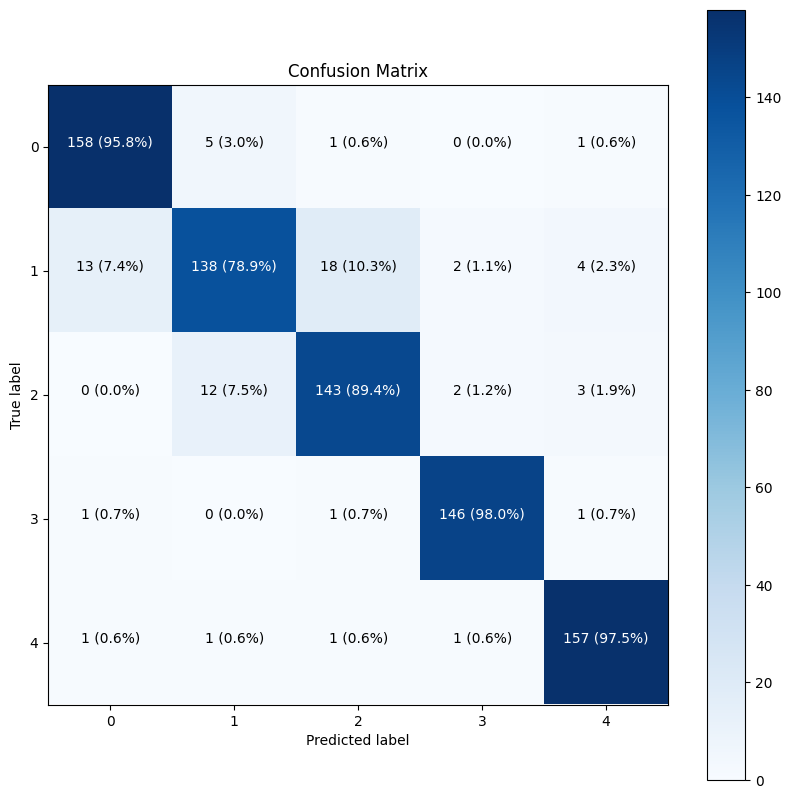

In [101]:
make_confusion_matrix(y_test,val)

In [104]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, val)
print("Accuracy is: ", acc*100)

Accuracy is:  91.60493827160494


In [102]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, val))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       165
         1.0       0.88      0.79      0.83       175
         2.0       0.87      0.89      0.88       160
         3.0       0.97      0.98      0.97       149
         4.0       0.95      0.98      0.96       161

    accuracy                           0.92       810
   macro avg       0.92      0.92      0.92       810
weighted avg       0.92      0.92      0.91       810



# Method My

In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [78]:
basemodel = tres(include_top=False,weights = 'imagenet')

In [80]:
data[0].shape

(64, 64, 3)